### NAME - AKHILESH JOSHI
### DIV - B 
### ROLL NO - 03
### SRN - 02FE22BCS013
### STOCK PRICE PREDICTION DATASET 

In [3]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# Load the dataset
data = pd.read_csv(r"C:\anaconda3\twitter-stocks.csv")

# Extract and normalize 'Close' prices
close_prices = data['Close'].values.reshape(-1, 1)
scaler = MinMaxScaler(feature_range=(0, 1))
normalized_prices = scaler.fit_transform(close_prices)

# Prepare sequences
seq_length = 5
x_data, y_data = [], []

for i in range(len(normalized_prices) - seq_length):
    x_data.append(normalized_prices[i:i + seq_length])
    y_data.append(normalized_prices[i + seq_length])

x_data = np.array(x_data)
y_data = np.array(y_data)

# Convert to PyTorch tensors
x_data = torch.tensor(x_data, dtype=torch.float32)
y_data = torch.tensor(y_data, dtype=torch.float32)

# Split data into training and test sets
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.2, random_state=42)

# Define the LSTM model
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=1):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

# Model parameters
input_size = 1
hidden_size = 50
output_size = 1
num_layers = 1

# Instantiate model, loss function, and optimizer
model = LSTMModel(input_size, hidden_size, output_size, num_layers)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# Training function
def train_model(model, x_train, y_train, num_epochs=100):
    for epoch in range(num_epochs):
        model.train()
        optimizer.zero_grad()
        outputs = model(x_train)
        loss = criterion(outputs, y_train)
        loss.backward()
        optimizer.step()

        if (epoch + 1) % 10 == 0:
            print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}')

# Train the model
train_model(model, x_train, y_train, num_epochs=100)

# Testing function
def evaluate_model(model, x_test, y_test):
    model.eval()
    with torch.no_grad():
        predictions = model(x_test)
        loss = criterion(predictions, y_test)
    print(f'Test Loss: {loss.item():.4f}')
    return predictions

# Evaluate the model
predictions = evaluate_model(model, x_test, y_test)

# Reverse normalization for predictions and ground truth
predicted_prices = scaler.inverse_transform(predictions.numpy())
actual_prices = scaler.inverse_transform(y_test.numpy())

# Display some predictions
for i in range(5):
    print(f"Predicted: {predicted_prices[i][0]:.2f}, Actual: {actual_prices[i][0]:.2f}")


Epoch [10/100], Loss: 0.0357
Epoch [20/100], Loss: 0.0059
Epoch [30/100], Loss: 0.0028
Epoch [40/100], Loss: 0.0016
Epoch [50/100], Loss: 0.0010
Epoch [60/100], Loss: 0.0009
Epoch [70/100], Loss: 0.0009
Epoch [80/100], Loss: 0.0008
Epoch [90/100], Loss: 0.0008
Epoch [100/100], Loss: 0.0008
Test Loss: 0.0008
Predicted: 35.53, Actual: 33.62
Predicted: 32.87, Actual: 31.06
Predicted: 49.62, Actual: 49.11
Predicted: 16.51, Actual: 17.05
Predicted: 27.50, Actual: 27.38


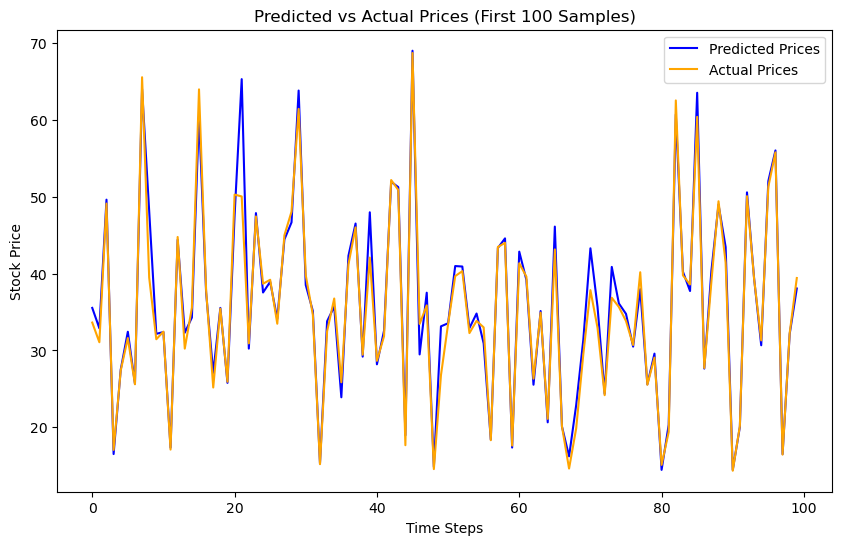

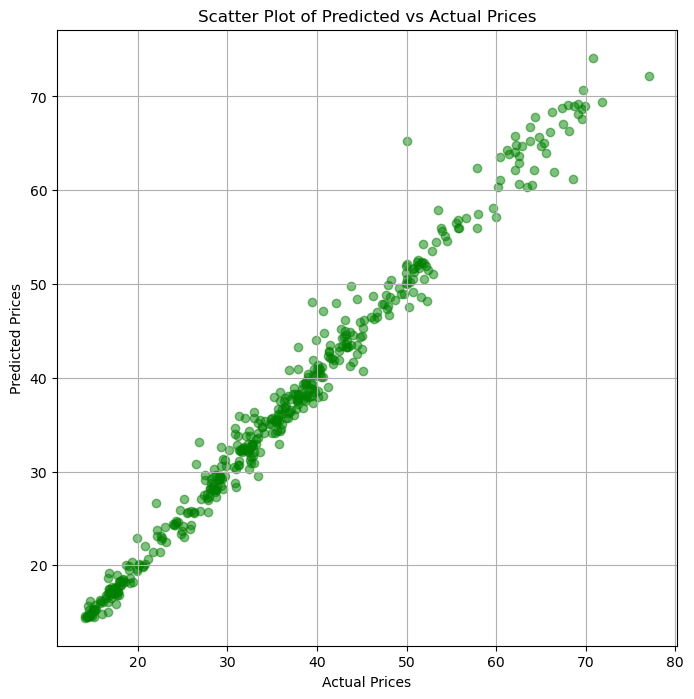

In [5]:
import matplotlib.pyplot as plt


# Plotting the first 100 predictions for better visibility
plt.figure(figsize=(10, 6))
plt.plot(predicted_prices[:100], label='Predicted Prices', color='blue')
plt.plot(actual_prices[:100], label='Actual Prices', color='orange')
plt.title('Predicted vs Actual Prices (First 100 Samples)')
plt.xlabel('Time Steps')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

# Scatter plot of predicted vs actual prices for performance evaluation
plt.figure(figsize=(8, 8))
plt.scatter(actual_prices, predicted_prices, alpha=0.5, color='green')
plt.title('Scatter Plot of Predicted vs Actual Prices')
plt.xlabel('Actual Prices')
plt.ylabel('Predicted Prices')
plt.grid(True)
plt.show()
